- **Model:** OLMo-2-1124-7B-SFT

<br>

- **Full gradient length:** 16,777,216

<br>

- **Considered projections of length:**
  - 2,048,000
  - 204,800
  - 16,384
  - 8,192

<br>

- **Considered the gradients on**  
   - 1000 train samples
   - 100 test samples

<br>

- **Original train set:**

  allenai/tulu-v2-sft-mixture

  https://huggingface.co/datasets/allenai/tulu-v2-sft-mixture (Considered ***1000 random samples***, seed = 42)

  I should have probably taken this one: https://huggingface.co/datasets/allenai/tulu-v2-sft-mixture-olmo-2048 as it is mentioned in the *OLMO: Accelerating the Science of Language Models* article. However, the only difference is that the latter is a bit more cleaned up and resplit at 2,080 tokens.
  
  With allenai/tulu-v2-sft-mixture, I did encounter only 1 instance where the sample was too long and resulted in all-zeros gradient, so it had to be excluded from the analysis. Therefore,  in reality, only 999 gradients for train set are considered.

  **Sample used:**

  https://huggingface.co/datasets/daryna3325/sampled-tulu-1000

<br>

- **Original test set:**  
  HuggingFaceH4/ultrachat_200k  
  https://huggingface.co/datasets/HuggingFaceH4/ultrachat_200k  
  (followed the format expected by our model, this is a filtered version of UltraChat dataset.  
  "Large-scale, Informative, and Diverse Multi-round Dialogue Data"  
  A bit general, no specific focus on testing model's bias or ethics of replies). Considered ***first 100***  samples.

  **Sample used:**

  https://huggingface.co/datasets/daryna3325/HFH4_ultrachat_200k_first100_samples

<br>

- **Considered similarity measures:**
  - Dot product
  - Cosine similarity

<br>


- **Considered rank correlation measures:**  
  - Kendall's tau
  - Spearman's rho
  - NDCG score

<br>


- **For the gradient calculation on test set,**  
  the model is still in the train mode but the dropout is disabled.


<br>

# Supplements:

The codes for gradient projection, similarity calculation can be found on https://github.com/DarynaKalinchuk/Gradient_dimensionality_reduction .

The samples and assigned scores files imported from SLURM: https://drive.google.com/drive/folders/13q8rYNA423X36kIFBJhGUhQbNGByzVx_?usp=sharing .

Or directly on SLURM: /srv/home/users/kalinchukd23cs/gradient_dimensionality_reduction_dap/explainability .

# Types of projections used

In [13]:
%%capture
!pip install traker

In [14]:
from trak.projectors import ProjectionType

print([e.name for e in ProjectionType])


['normal', 'rademacher']


------------------------------------------

In [15]:
import os
import json
import gc
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator

from scipy.stats import kendalltau, spearmanr
from sklearn.metrics import ndcg_score

import seaborn as sns
import pandas as pd

from collections import defaultdict

from tabulate import tabulate

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
base_path = '/content/drive/My Drive/explainability'

folders = {
    'full': {
        'dot': f'{base_path}/16777216/OLMO/dot',
        'cosine': f'{base_path}/16777216/OLMO/cosine',
    },
    'rademacher': {
        '2048000': {
            'dot': f'{base_path}/2048000/OLMO/rademacher/dot',
            'cosine': f'{base_path}/2048000/OLMO/rademacher/cosine',
        },
        '204800': {
            'dot': f'{base_path}/204800/OLMO/rademacher/dot',
            'cosine': f'{base_path}/204800/OLMO/rademacher/cosine',
        },
        '16384': {
            'dot': f'{base_path}/16384/OLMO/rademacher/dot',
            'cosine': f'{base_path}/16384/OLMO/rademacher/cosine',
        },
        '8192': {
            'dot': f'{base_path}/8192/OLMO/rademacher/dot',
            'cosine': f'{base_path}/8192/OLMO/rademacher/cosine',
        },
    },
    'normal': {
        '2048000': {
            'dot': f'{base_path}/2048000/OLMO/normal/dot',
            'cosine': f'{base_path}/2048000/OLMO/normal/cosine',
        },
        '204800': {
            'dot': f'{base_path}/204800/OLMO/normal/dot',
            'cosine': f'{base_path}/204800/OLMO/normal/cosine',
        },
        '16384': {
            'dot': f'{base_path}/16384/OLMO/normal/dot',
            'cosine': f'{base_path}/16384/OLMO/normal/cosine',
        },
        '8192': {
            'dot': f'{base_path}/8192/OLMO/normal/dot',
            'cosine': f'{base_path}/8192/OLMO/normal/cosine',
        },
    }
}


# Main results

Violin plots for the different correlation measure distributions, different projection dimensions.

<br>

Rankings from scores for
- **cosine similarity full vs. cosine similarity projected**
- **dot product full vs. dot product projected**

are considered.

<br>

P-values are for the permutation test for median differences (1000 permutations), results reproducible. Details are in the report.

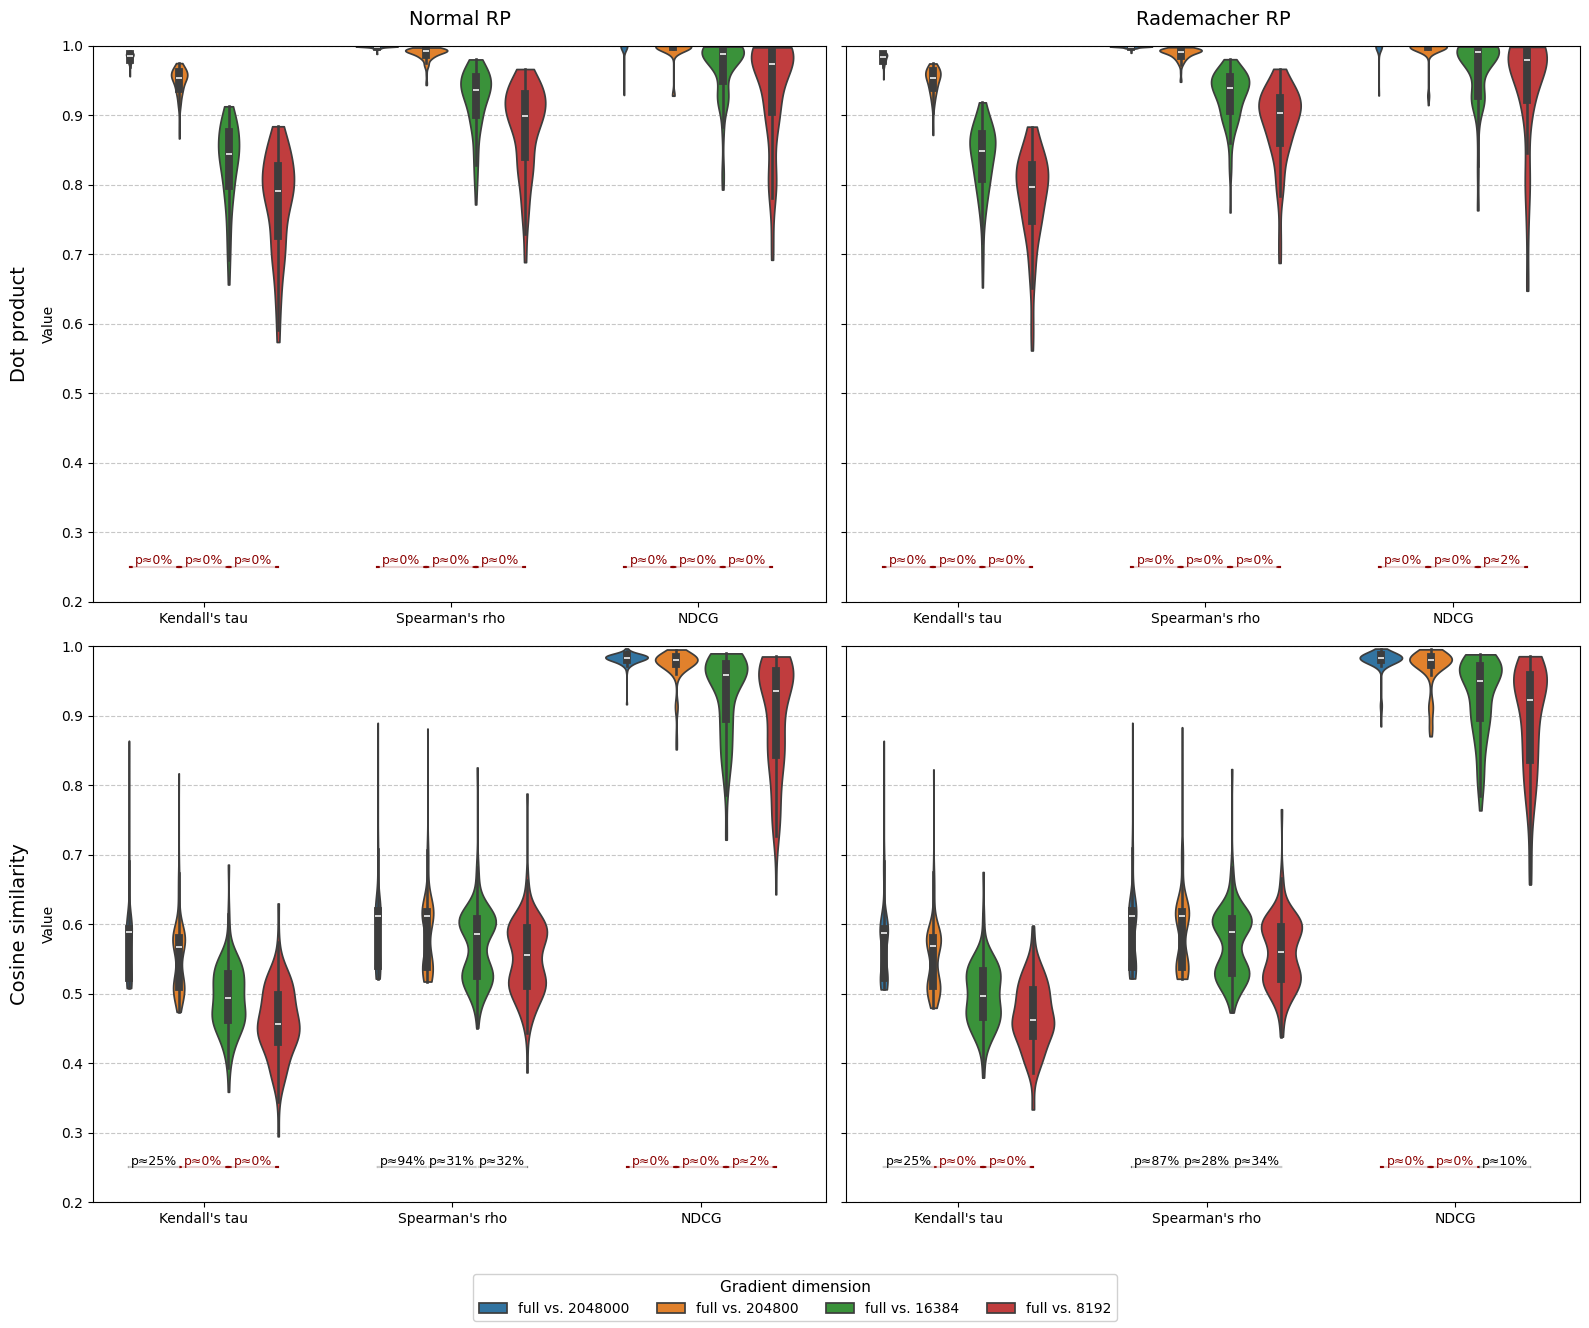

In [18]:
nan_id_cosine = "open_orca_t0.1598436"

def load_json_files(folder):
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.json')]
    files.sort()
    data = []
    for file_ in files:
        with open(file_, 'r') as f:
            items = json.load(f)
            items = [item for item in items if item['id'] != nan_id_cosine]
            data.append(items)
    return data

def compute_metric(data_a, data_b, metric='kendall'):
    scores = []
    for i in range(100):
        a = data_a[i]
        b = data_b[i]
        ids_a = [item['id'] for item in a]
        ranks_a = {id_: rank for rank, id_ in enumerate(ids_a)}
        ranks_b = {id_: rank for rank, id_ in enumerate([item['id'] for item in b])}
        rank_list_a = [ranks_a[id_] for id_ in ids_a]
        rank_list_b = [ranks_b[id_] for id_ in ids_a]
        if metric == 'kendall':
            score, _ = kendalltau(rank_list_a, rank_list_b)
        elif metric == 'spearman':
            score, _ = spearmanr(rank_list_a, rank_list_b)
        elif metric == 'ndcg':
            relevance = [1 / (r + 1) for r in rank_list_a]
            predicted_scores = [1 / (r + 1) for r in rank_list_b]
            score = ndcg_score([relevance], [predicted_scores])
        scores.append(score)
    return scores

def prepare_data_for_plot(data_metrics_by_sample, metric_labels, sample_labels):
    records = []
    for sample_label, metrics in zip(sample_labels, data_metrics_by_sample):
        for metric_name, values in zip(metric_labels, metrics):
            for val in values:
                records.append({
                    "Sample": sample_label,
                    "Metric": metric_name,
                    "Score": val
                })
    return pd.DataFrame(records)

def perform_median_tests(data_metrics, sample_labels, metric_labels, random_state=42, n_permutations=1000):
    """Perform permutation tests comparing medians between consecutive dimensions."""

    rng = np.random.default_rng(random_state)

    p_values_dict = {}
    for metric_idx, metric_name in enumerate(metric_labels):
        p_values = []
        for i in range(len(data_metrics) - 1):
            scores1 = data_metrics[i][metric_idx]
            scores2 = data_metrics[i+1][metric_idx]

            # Observed median difference
            obs_diff = np.median(scores1) - np.median(scores2)

            # Permutation
            combined = np.concatenate([scores1, scores2])
            n1 = len(scores1)
            perm_diffs = []
            for _ in range(n_permutations):
                perm_combined = rng.permutation(combined)
                perm_diff = np.median(perm_combined[:n1]) - np.median(perm_combined[n1:])
                perm_diffs.append(perm_diff)

            p_value = np.mean(np.abs(perm_diffs) >= abs(obs_diff))
            p_values.append(p_value)

        p_values_dict[metric_name] = p_values
    return p_values_dict

def add_p_value_annotations(ax, p_values, x_positions):
    """Add p-value annotations between violin plots with better positioning"""
    y_pos = ax.get_ylim()[0] + 0.05  # Fixed y-position slightly above x-axis

    for i, p_val in enumerate(p_values):
        x1 = x_positions[i]
        x2 = x_positions[i+1]
        line_color = 'darkred' if p_val < 0.05 else 'black'
        text_color = 'darkred' if p_val < 0.05 else 'black'

        ax.plot([x1, x2], [y_pos, y_pos],
                color=line_color, linestyle='-', linewidth=1.5, alpha=0.9)
        arrow_length = 0.02 * (x2 - x1)
        ax.plot([x1 + arrow_length, x1], [y_pos, y_pos],
                color=line_color, linestyle='-', linewidth=1.5, alpha=0.9)
        ax.plot([x2 - arrow_length, x2], [y_pos, y_pos],
                color=line_color, linestyle='-', linewidth=1.5, alpha=0.9)

        p_text = f"p≈{int(round(p_val * 100))}%"
        ax.text((x1 + x2)/2, y_pos, p_text,
                ha='center', va='bottom', fontsize=9, color=text_color,
                bbox=dict(facecolor='white', alpha=0.8,
                         edgecolor='none', boxstyle='round,pad=0.2'))

def generate_plot_data(base_folder, variant_folders):
    base_data = load_json_files(base_folder)
    data_metrics = []
    sample_labels = []
    for folder in variant_folders:
        variant_data = load_json_files(folder)
        kendall = compute_metric(base_data, variant_data, 'kendall')
        spearman = compute_metric(base_data, variant_data, 'spearman')
        ndcg = compute_metric(base_data, variant_data, 'ndcg')
        data_metrics.append([kendall, spearman, ndcg])

        path_parts = folder.split('/')
        dimension = path_parts[-4]
        sample_labels.append(f"full vs. {dimension}")

        del variant_data
        gc.collect()

    p_values_dict = perform_median_tests(data_metrics, sample_labels, ["Kendall's tau", "Spearman's rho", "NDCG"])

    del base_data
    gc.collect()
    return prepare_data_for_plot(data_metrics, ["Kendall's tau", "Spearman's rho", "NDCG"], sample_labels), p_values_dict

def plot_all_four(df_list, p_values_list, row_labels, col_labels, show_p_values=True):
    fig, axs = plt.subplots(2, 2, figsize=(16, 14), sharey=True)

    for i in range(2):
        for j in range(2):
            ax = axs[i, j]
            idx = i * 2 + j
            df = df_list[idx]
            p_values_dict = p_values_list[idx]

            sns.violinplot(data=df, x="Metric", y="Score", hue="Sample",
                          inner="box", cut=0, ax=ax, width=0.8, gap=0.15)
            ax.set_ylabel("Value" if j == 0 else "")
            ax.set_xlabel("")
            ax.set_ylim(0.2, 1.0)
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            ax.set_axisbelow(True)

            if j > 0:
                ax.tick_params(labelleft=False)

            if show_p_values:
                for metric_idx, metric in enumerate(["Kendall's tau", "Spearman's rho", "NDCG"]):
                    if metric in p_values_dict:
                        n_samples = len(df['Sample'].unique())
                        x_centers = [metric_idx + (k - (n_samples-1)/2)*0.2 for k in range(n_samples)]
                        add_p_value_annotations(ax, p_values_dict[metric], x_centers)

    for j, col in enumerate(col_labels):
        axs[0, j].set_title(col, fontsize=14, pad=15)

    for i, row in enumerate(row_labels):
        axs[i, 0].annotate(
            row,
            xy=(0, 0.5),
            xytext=(-axs[i, 0].yaxis.labelpad - 5, 0),
            xycoords=axs[i, 0].yaxis.label,
            textcoords='offset points',
            fontsize=14,
            ha='right',
            va='center',
            rotation=90
        )

    handles, labels = axs[0, 0].get_legend_handles_labels()
    for ax in axs.flatten():
        ax.get_legend().remove()
    fig.legend(handles, labels, title="Gradient dimension", loc='lower center', ncol=4,
               prop={'size': 10}, framealpha=0.9,
               title_fontsize=11)

    plt.tight_layout(rect=[0, 0.06, 1, 0.95])
    plt.show()


dot_normal_df, dot_normal_p = generate_plot_data(
    base_folder=folders['full']['dot'],
    variant_folders=[
        folders['normal']['2048000']['dot'],
        folders['normal']['204800']['dot'],
        folders['normal']['16384']['dot'],
        folders['normal']['8192']['dot'],
    ]
)

dot_rademacher_df, dot_rademacher_p = generate_plot_data(
    base_folder=folders['full']['dot'],
    variant_folders=[
        folders['rademacher']['2048000']['dot'],
        folders['rademacher']['204800']['dot'],
        folders['rademacher']['16384']['dot'],
        folders['rademacher']['8192']['dot'],
    ]
)

cosine_normal_df, cosine_normal_p = generate_plot_data(
    base_folder=folders['full']['cosine'],
    variant_folders=[
        folders['normal']['2048000']['cosine'],
        folders['normal']['204800']['cosine'],
        folders['normal']['16384']['cosine'],
        folders['normal']['8192']['cosine'],
    ]
)

cosine_rademacher_df, cosine_rademacher_p = generate_plot_data(
    base_folder=folders['full']['cosine'],
    variant_folders=[
        folders['rademacher']['2048000']['cosine'],
        folders['rademacher']['204800']['cosine'],
        folders['rademacher']['16384']['cosine'],
        folders['rademacher']['8192']['cosine'],
    ]
)

plot_all_four(
    df_list=[dot_normal_df, dot_rademacher_df, cosine_normal_df, cosine_rademacher_df],
    p_values_list=[dot_normal_p, dot_rademacher_p, cosine_normal_p, cosine_rademacher_p],
    row_labels=["Dot product", "Cosine similarity"],
    col_labels=["Normal RP", "Rademacher RP"],
    show_p_values=True
)

# The structure of the data (example):

(The second most influential train sample for the model's answer to the test sample 0;

Score is calculated using cosine similarity in this case; gradients are projected into dim 2,048,000 using Rademacher RP)

In [19]:
load_json_files(folders['rademacher']['2048000']['cosine'])[0][1]

{'score': 0.09160212427377701,
 'dataset': 'code_alpaca',
 'id': 'code_alpaca_2770',
 'messages': [{'role': 'user',
   'content': 'Create a HTML div tag with the following attributes: width="400px" and background-color="#00FFFF".'},
  {'role': 'assistant',
   'content': '\n<div style="width: 400px; background-color: #00FFFF;"></div>'}]}

# Scores distribution plots

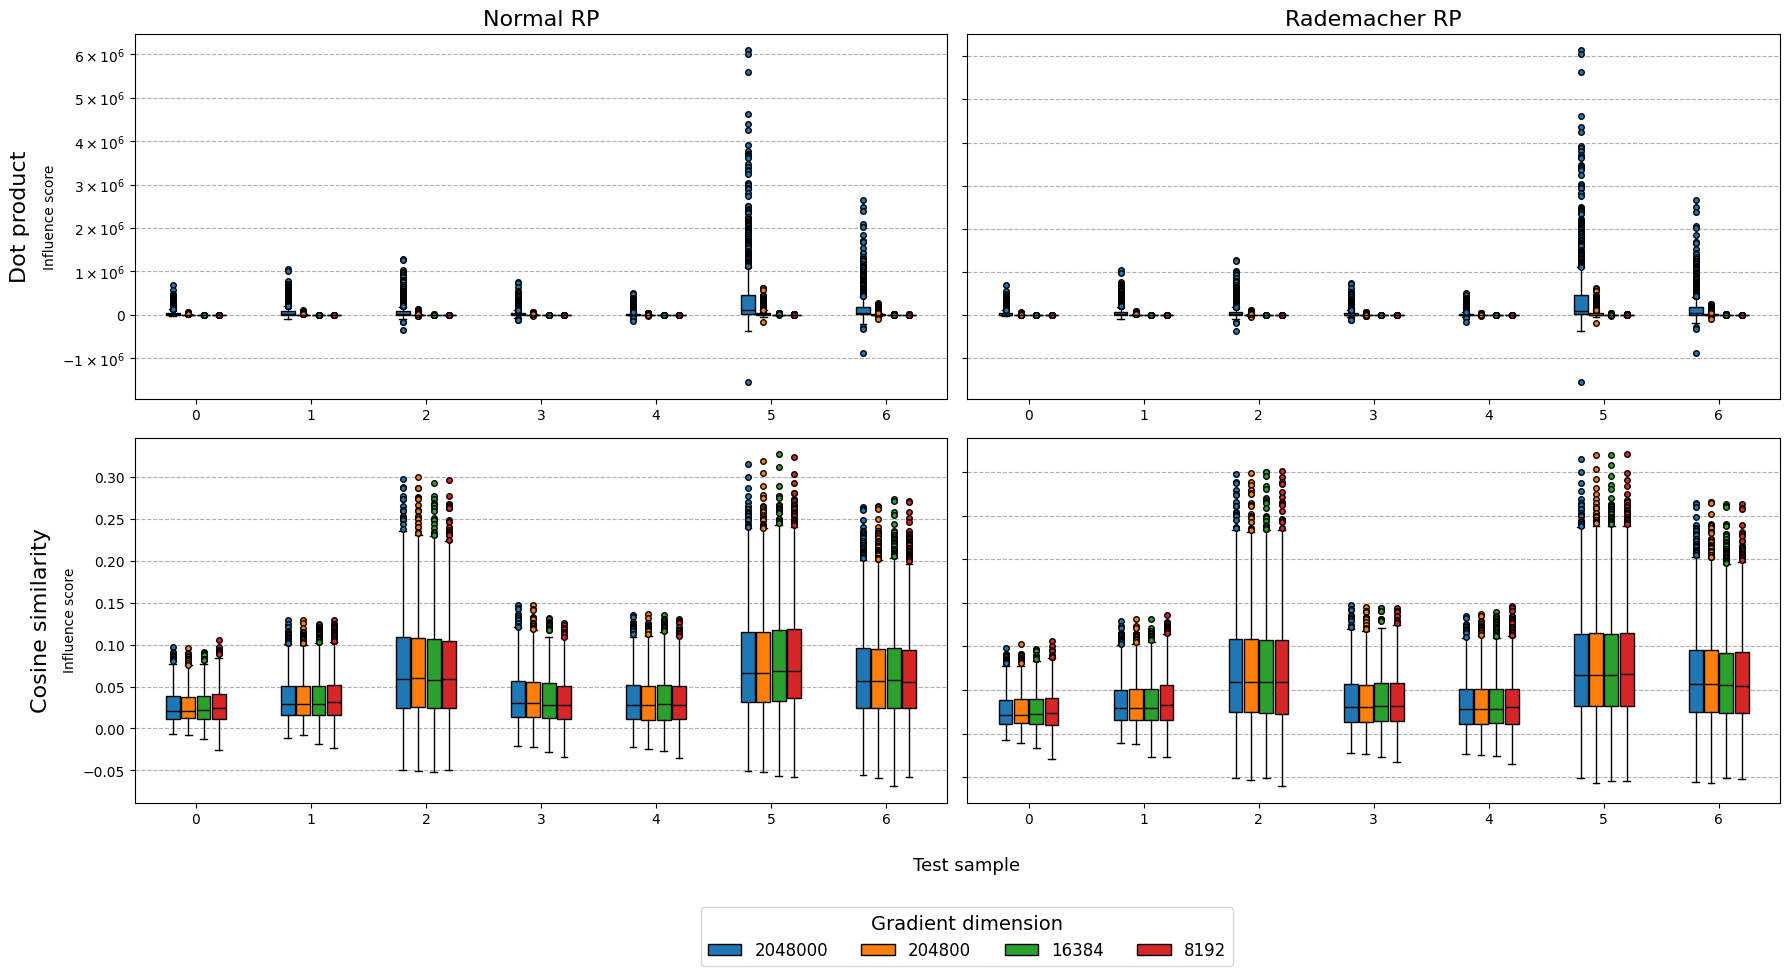

In [20]:
def prepare_score_data(folder, n_files=7):
    """Load and format score data from JSON files."""
    data = load_json_files(folder)
    records = [
        {"File": str(i), "Score": score}
        for i in range(n_files)
        for score in [item['score'] for item in data[i]]
    ]
    del data
    gc.collect()
    return pd.DataFrame(records)

def run_visualization(plot_type='matrix', show_fliers=True, row_labels=None, col_labels=None):
    """Run the complete visualization pipeline."""
    # Data generation
    if plot_type == 'full':
        df_list = (
            prepare_score_data(folders['full']['dot']).assign(Sample="full (16,777,216)"),
            prepare_score_data(folders['full']['cosine']).assign(Sample="full (16,777,216)")
        )
    else:  # matrix
        def process_data(kind, dist):
            paths = [folders[dist][size][kind] for size in ["2048000", "204800", "16384", "8192"]]
            dfs = [prepare_score_data(path) for path in paths]
            for df, label in zip(dfs, ["2048000", "204800", "16384", "8192"]):
                df["Sample"] = label
            return pd.concat(dfs)

        df_list = [
            process_data('dot', 'normal'),
            process_data('dot', 'rademacher'),
            process_data('cosine', 'normal'),
            process_data('cosine', 'rademacher')
        ]

    # Plot configuration
    default_labels = {
        'matrix': {
            'row_labels': ["Dot product", "Cosine similarity"],
            'col_labels': ["Normal RP", "Rademacher RP"]
        },
        'full': {
            'row_labels': [],
            'col_labels': []
        }
    }

    config = {
        'plot_type': plot_type,
        'show_fliers': show_fliers,
        'row_labels': row_labels or default_labels[plot_type]['row_labels'],
        'col_labels': col_labels or default_labels[plot_type]['col_labels']
    }

    # Plotting
    def create_box_plot(ax, df, use_sci_notation=False):
        def sci_notation(x, _):
            if x == 0: return "0"
            exponent = int(np.floor(np.log10(abs(x))))
            base = x / 10**exponent
            return r"${0:.0f} \times 10^{{{1}}}$".format(base, exponent)

        files = sorted(df["File"].unique())
        samples = sorted(df["Sample"].unique(), key=lambda x: int(x), reverse=True)

        group_spacing = 1.5
        width = 0.8 / len(samples)

        for s_idx, sample in enumerate(samples):
            positions = np.arange(len(files)) * group_spacing + s_idx * width - 0.4 + width / 2
            box_data = [df[(df["File"] == f) & (df["Sample"] == sample)]["Score"].values for f in files]
            ax.boxplot(
                box_data,
                positions=positions,
                widths=width * 0.9,
                patch_artist=True,
                boxprops=dict(facecolor=f"C{s_idx}"),
                medianprops=dict(color='black'),
                showfliers=config['show_fliers'],
                flierprops=dict(markerfacecolor=f"C{s_idx}", marker='o', markersize=4, linestyle='none') if config['show_fliers'] else None,
            )

        ax.set_xticks(np.arange(len(files)) * group_spacing)
        ax.set_xticklabels(files)
        ax.grid(True, axis='y', linestyle='--')
        ax.grid(False, axis='x')
        ax.set_axisbelow(True)
        if use_sci_notation:
            ax.yaxis.set_major_formatter(FuncFormatter(sci_notation))
        return samples

    if plot_type == 'full':
        fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharey=False)
        dot_df, cosine_df = df_list
        dot_df['Measure'] = 'Dot product'
        cosine_df['Measure'] = 'Cosine similarity'
        combined_df = pd.concat([dot_df, cosine_df])

        for i, measure in enumerate(['Dot product', 'Cosine similarity']):
            ax = axs[i]
            measure_df = combined_df[combined_df['Measure'] == measure]

            sns.boxplot(
                data=measure_df,
                x="File",
                y="Score",
                hue="Sample",
                ax=ax,
                palette="deep",
                width=0.6,
                showfliers=config['show_fliers'],
                fliersize=3
            )

            ax.set_title(f"\n {measure}", fontsize=12)
            ax.set_xlabel("")
            ax.set_ylabel("Influence score")
            ax.grid(axis='y', linestyle='--')
            ax.set_axisbelow(True)
            ax.get_legend().remove()

        fig.supxlabel("Test sample", fontsize=11, y=0.12, x=0.53)
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(
            handles,
            labels,
            title="Gradient dimension",
            loc='upper center',
            bbox_to_anchor=(0.53, 0.07),
            ncol=1,
            prop={'size': 11},
            title_fontsize=12
        )

    else:  # matrix
        fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharey=False)
        for i, row in enumerate(config['row_labels']):
            for j, col in enumerate(config['col_labels']):
                current_ax = ax[i,j]

                samples = create_box_plot(current_ax, df_list[i*2 + j], use_sci_notation=(i == 0))
                current_ax.set_xlabel("")
                current_ax.set_ylabel("Influence score" if j == 0 else "")
                if j > 0: current_ax.tick_params(labelleft=False)
                if i == 0: current_ax.set_title(col, fontsize=16)

                if j == 0:
                    current_ax.annotate(
                        row, xy=(0, 0.5), xytext=(-current_ax.yaxis.labelpad -5, 0),
                        xycoords=current_ax.yaxis.label, textcoords='offset points',
                        fontsize=16, ha='right', va='center', rotation=90
                    )

        legend_patches = [plt.Rectangle((0,0),1,1, facecolor=f"C{i}", edgecolor='black') for i in range(len(samples))]
        fig.legend(
            legend_patches, samples, title="Gradient dimension",
            loc='lower center', ncol=4, bbox_to_anchor=(0.54, 0.02),
            prop={'size': 12}, title_fontsize=14
        )
        fig.supxlabel("Test sample", fontsize=13, y=0.12, x=0.54)

    plt.tight_layout(rect=[0, 0.12 if plot_type == 'matrix' else 0.1, 1, 1])
    plt.show()


run_visualization(plot_type='matrix')

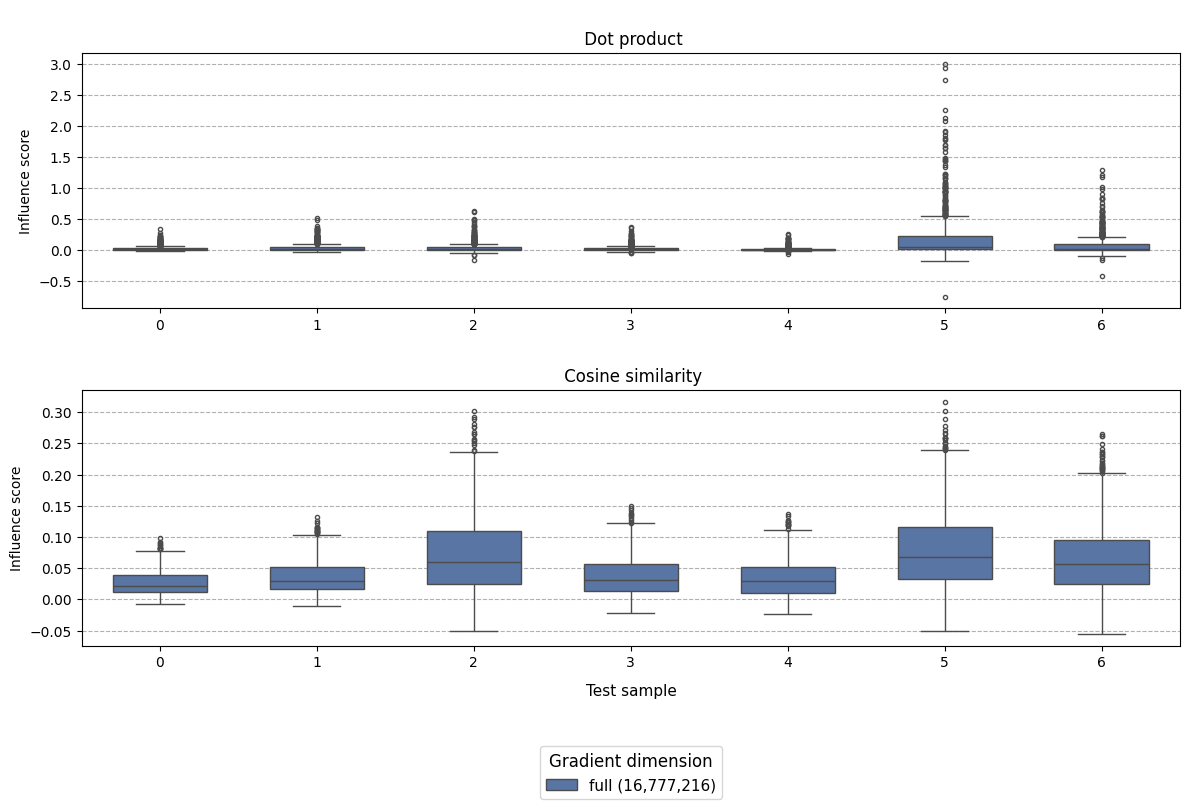

In [21]:
run_visualization(plot_type='full')

# Mean standard deviation within train score distributions, for the 100 test file results.

(so means of the 100 standard dev. values)

In [22]:
def compute_mean_std(folder):
    data = load_json_files(folder)
    stds = []

    for items in data:
        scores = np.array([item['score'] for item in items])
        stds.append(np.std(scores))

    return np.mean(stds) if stds else float('nan')

dot_folders = {
    'full': folders['full']['dot'],
    **{k: v['dot'] for k, v in folders['normal'].items()}
}

cosine_folders = {
    'full': folders['full']['cosine'],
    **{k: v['cosine'] for k, v in folders['normal'].items()}
}


# Prepare DOT data
dot_data = []
for dim, folder in dot_folders.items():
    mean_std = compute_mean_std(folder)
    dot_data.append([dim, f"{mean_std:,.2f}"])

# Prepare COSINE data
cosine_data = []
for dim, folder in cosine_folders.items():
    mean_std = compute_mean_std(folder)
    cosine_data.append([dim, f"{mean_std:,.4f}"])

# Print tables
print("--- DOT PRODUCT ---")
print(tabulate(dot_data, headers=["Gradient dim", "Mean std dev"], tablefmt="grid"))
print("\n--- COSINE SIMILARITY ---")
print(tabulate(cosine_data, headers=["Gradient dim", "Mean std dev"], tablefmt="grid"))

--- DOT PRODUCT ---
+----------------+----------------+
| Gradient dim   | Mean std dev   |
+================+================+
| full           | 0.13           |
+----------------+----------------+
| 2048000        | 261,225.92     |
+----------------+----------------+
| 204800         | 26,121.02      |
+----------------+----------------+
| 16384          | 2,131.61       |
+----------------+----------------+
| 8192           | 1,079.23       |
+----------------+----------------+

--- COSINE SIMILARITY ---
+----------------+----------------+
| Gradient dim   |   Mean std dev |
+================+================+
| full           |         0.0419 |
+----------------+----------------+
| 2048000        |         0.0415 |
+----------------+----------------+
| 204800         |         0.0415 |
+----------------+----------------+
| 16384          |         0.0419 |
+----------------+----------------+
| 8192           |         0.0418 |
+----------------+----------------+


# Kendall's tau between score rankings from dot vs. cosine within the same dimension


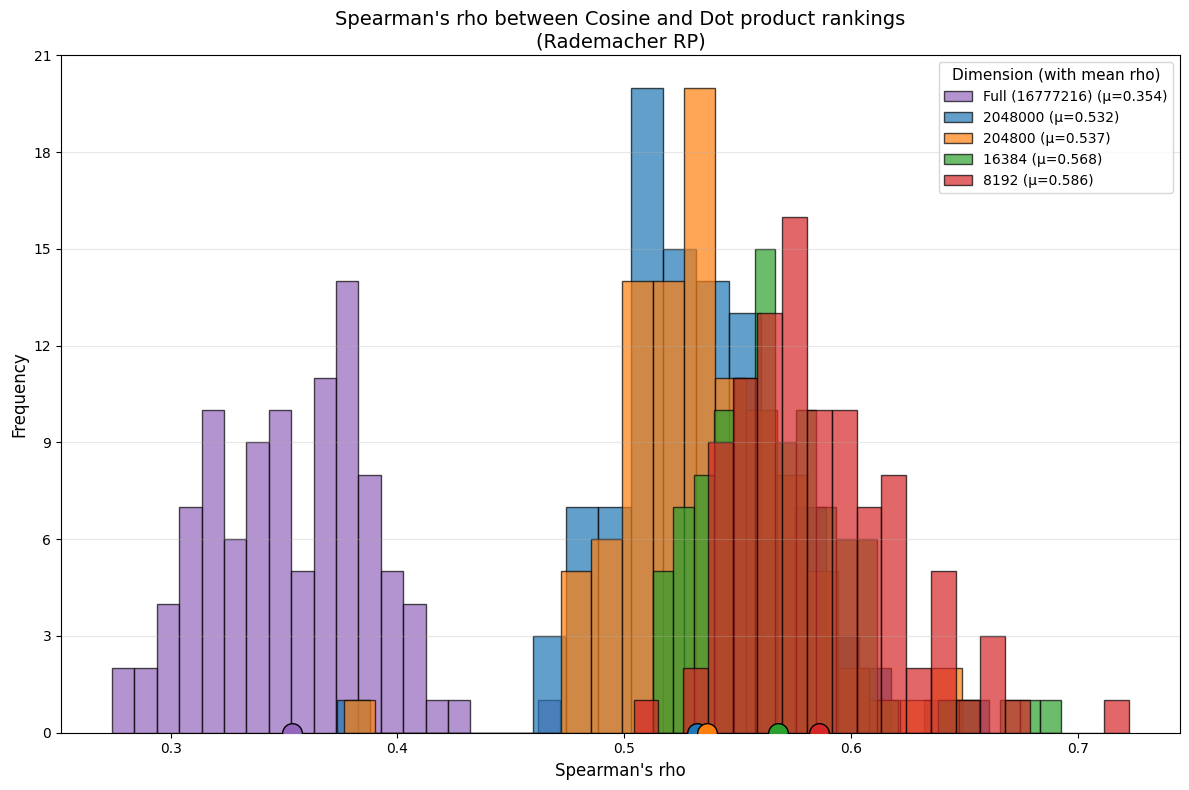

In [23]:
dimensions = {
    'Full (16777216)': (folders['full']['cosine'], folders['full']['dot']),
    '2048000': (folders['rademacher']['2048000']['cosine'], folders['rademacher']['2048000']['dot']),
    '204800': (folders['rademacher']['204800']['cosine'], folders['rademacher']['204800']['dot']),
    '16384': (folders['rademacher']['16384']['cosine'], folders['rademacher']['16384']['dot']),
    '8192': (folders['rademacher']['8192']['cosine'], folders['rademacher']['8192']['dot'])
}

tau_results = {}
for dim, (cos_path, dot_path) in dimensions.items():
    cosine_data = load_json_files(cos_path)
    dot_data = load_json_files(dot_path)
    tau_results[dim] = compute_metric(cosine_data, dot_data, metric='spearman')

# Plot histograms
plt.figure(figsize=(12, 8))
colors = ['#9467bd', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Calculate means and store them
means = {dim: np.mean(scores) for dim, scores in tau_results.items()}

for i, (dim, scores) in enumerate(tau_results.items()):
    plt.hist(scores, bins=20, alpha=0.7, label=f"{dim} (μ={means[dim]:.3f})",
             edgecolor='black', color=colors[i % len(colors)])

    plt.scatter(means[dim], 0, color=colors[i % len(colors)],
                s=200, marker='o', edgecolor='black', zorder=5)

plt.title("Spearman's rho between Cosine and Dot product rankings\n(Rademacher RP)", fontsize=14)
plt.xlabel("Spearman's rho", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(title='Dimension (with mean rho)', fontsize=10, title_fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

# Violins for cross comparison

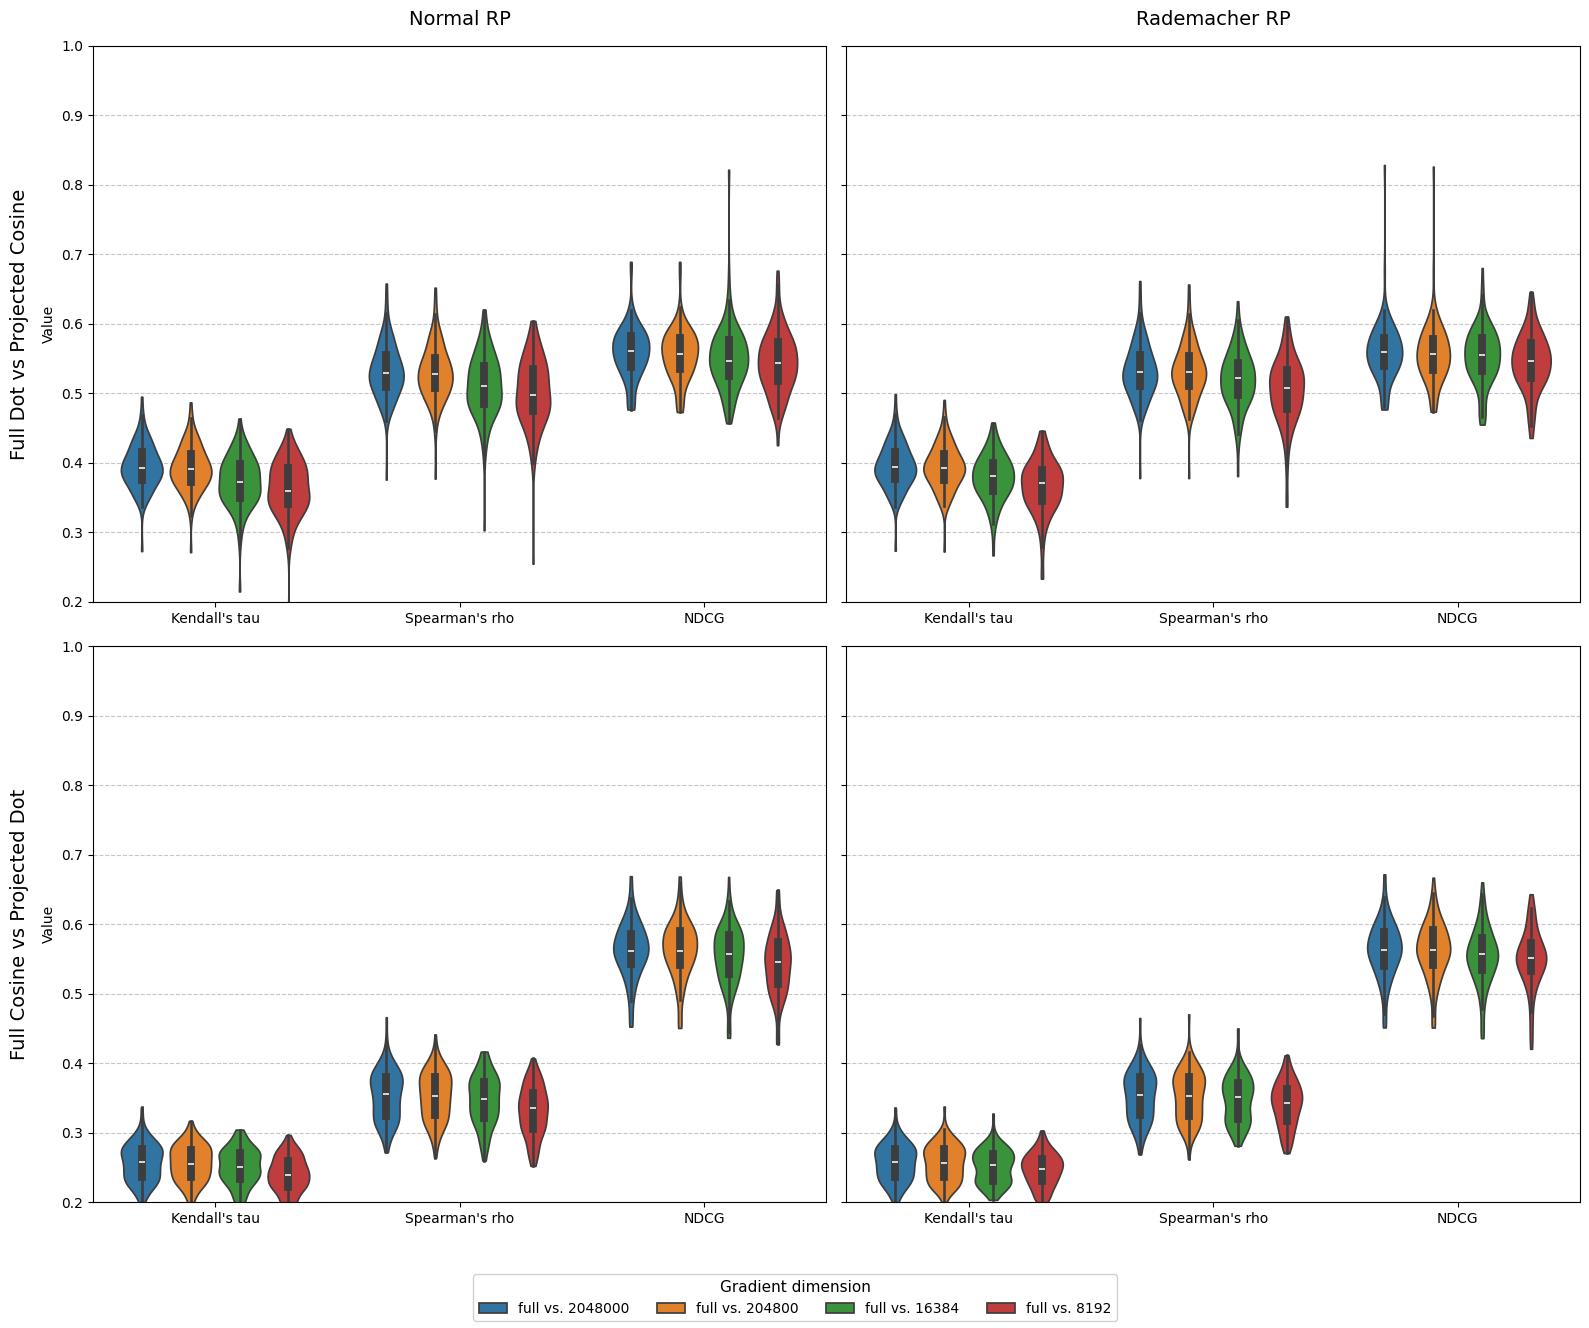

In [24]:
def generate_cross_plot_data(full_method, projected_method, projection_type):
    """Generate plot data comparing full method vs projected method"""
    base_folder = folders['full'][full_method]

    variant_folders = [
        folders[projection_type]['2048000'][projected_method],
        folders[projection_type]['204800'][projected_method],
        folders[projection_type]['16384'][projected_method],
        folders[projection_type]['8192'][projected_method],
    ]

    return generate_plot_data(base_folder, variant_folders)


# Generate all cross-comparison data
dot_vs_cosine_normal_df, dot_vs_cosine_normal_p = generate_cross_plot_data('dot', 'cosine', 'normal')
dot_vs_cosine_rademacher_df, dot_vs_cosine_rademacher_p = generate_cross_plot_data('dot', 'cosine', 'rademacher')
cosine_vs_dot_normal_df, cosine_vs_dot_normal_p = generate_cross_plot_data('cosine', 'dot', 'normal')
cosine_vs_dot_rademacher_df, cosine_vs_dot_rademacher_p = generate_cross_plot_data('cosine', 'dot', 'rademacher')

# Plot all comparisons
plot_all_four(
    df_list=[
        dot_vs_cosine_normal_df,
        dot_vs_cosine_rademacher_df,
        cosine_vs_dot_normal_df,
        cosine_vs_dot_rademacher_df
    ],
    p_values_list=[
        dot_vs_cosine_normal_p,
        dot_vs_cosine_rademacher_p,
        cosine_vs_dot_normal_p,
        cosine_vs_dot_rademacher_p
    ],
    row_labels=["Full Dot vs Projected Cosine", "Full Cosine vs Projected Dot"],
    col_labels=["Normal RP", "Rademacher RP"],
    show_p_values=False
)